In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [102]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [103]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [104]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [105]:
y =train_df['y']
y.head()

0    0
1    0
2    0
3    0
4    1
Name: y, dtype: int64

In [106]:
train_df.drop(columns ='y', inplace = True)

## Basic Checks

In [108]:
train_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown


In [109]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [110]:
train_df.shape

(750000, 17)

In [111]:
test_df.shape

(250000, 17)

In [112]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
dtypes: int64(8), object(9)
memory usage: 97.3+ MB


In [113]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000


In [114]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


In [115]:
test_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,874999.500000,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,72168.927986,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,750000.000000,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,812499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,874999.500000,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,937499.250000,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,999999.000000,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


In [116]:
train_df.isnull().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [117]:
train_df.duplicated().sum()

0

- No null values
- No Duplicate Values

## EDA

Numerical columns : ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


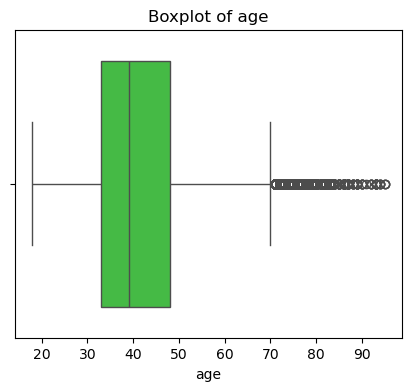

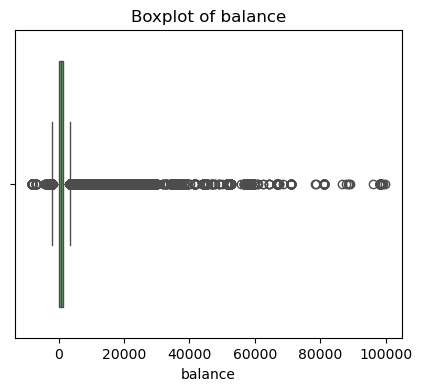

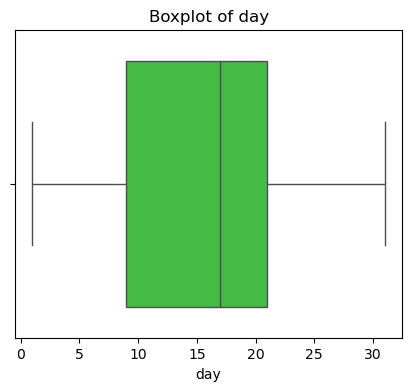

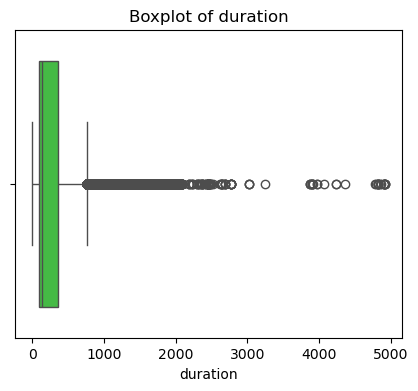

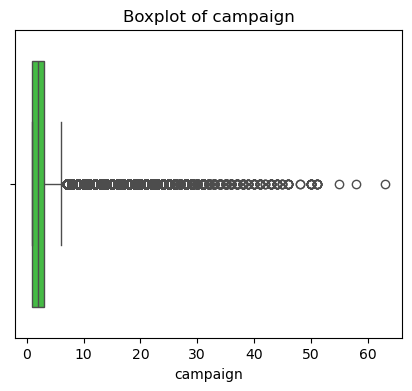

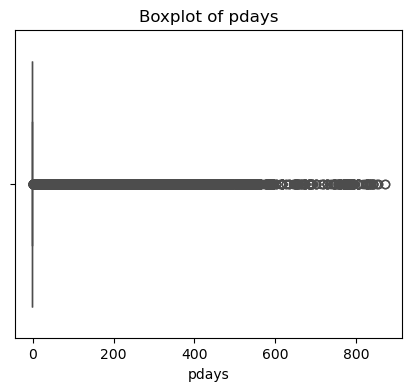

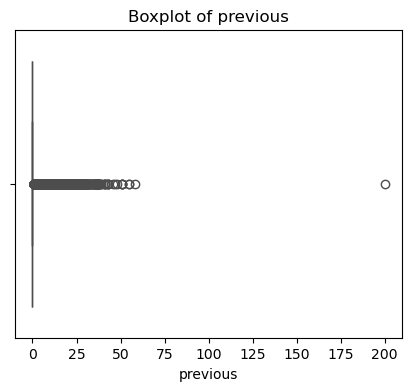

In [118]:
num_col = [col for col in train_df.columns if train_df[col].dtype != 'object' and col != 'id']
print(f"Numerical columns : {num_col}")
for col in num_col:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=train_df[col], color ='limegreen')  # y='y' groups by target
    plt.title(f"Boxplot of {col}")
    plt.show()

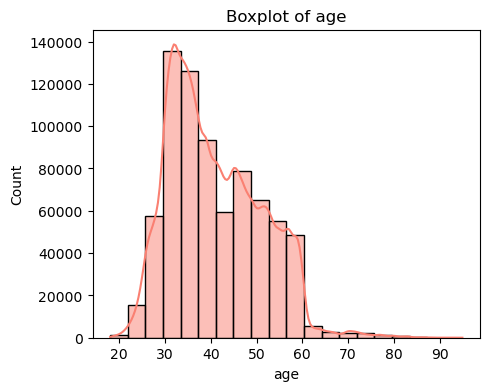

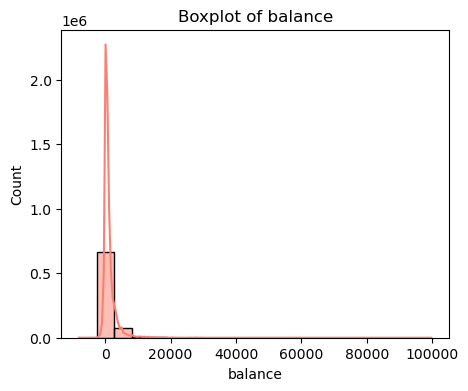

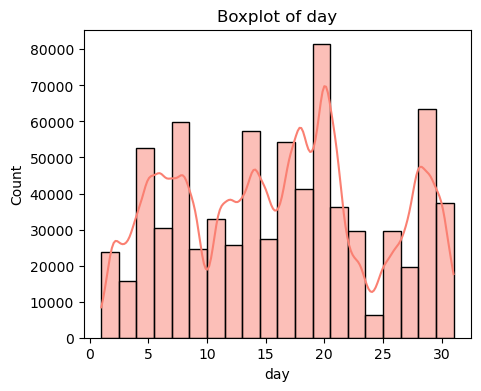

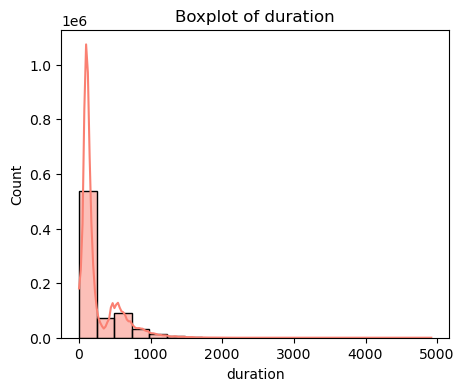

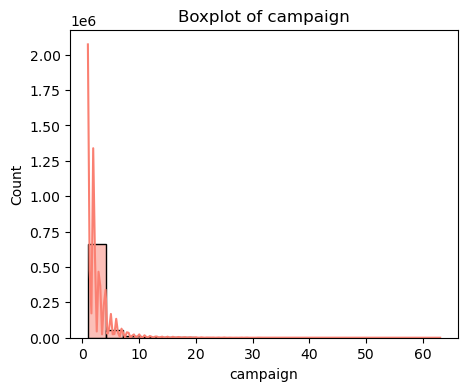

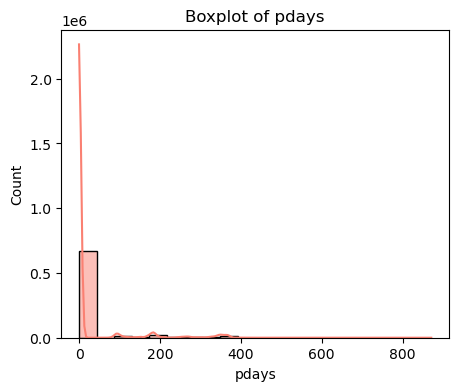

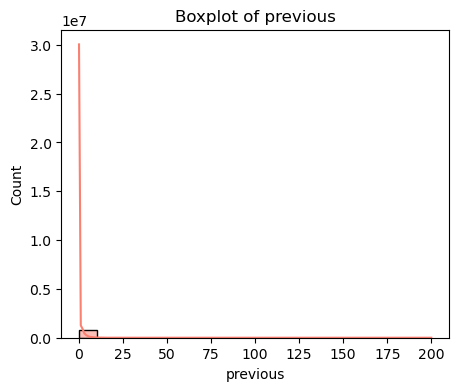

In [119]:
for col in num_col:
    plt.figure(figsize=(5,4))
    sns.histplot(x=train_df[col], kde =True, color = "salmon",bins =20)  
    plt.title(f"Boxplot of {col}")
    plt.show()

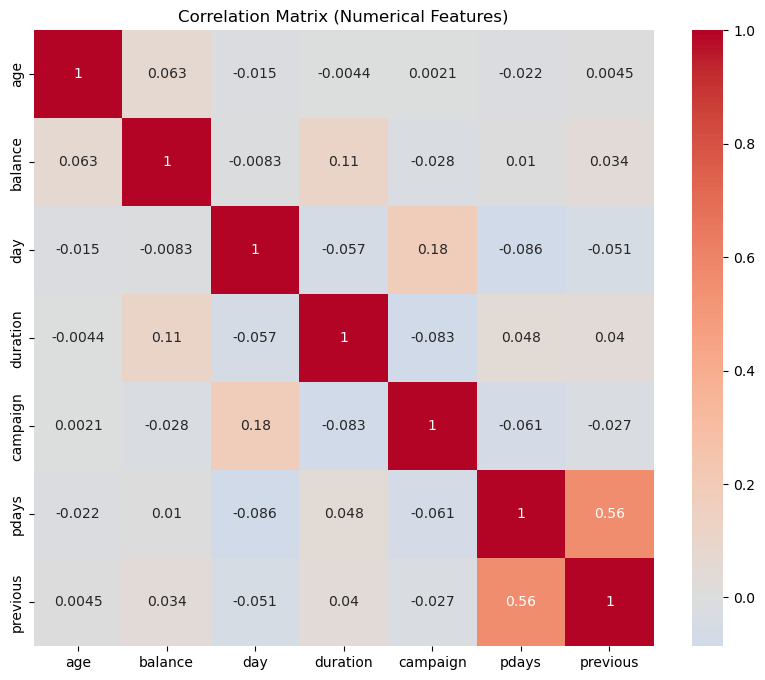

In [120]:
corr = train_df[num_col].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

- Very less relationship between the features

Categorical columns : Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')


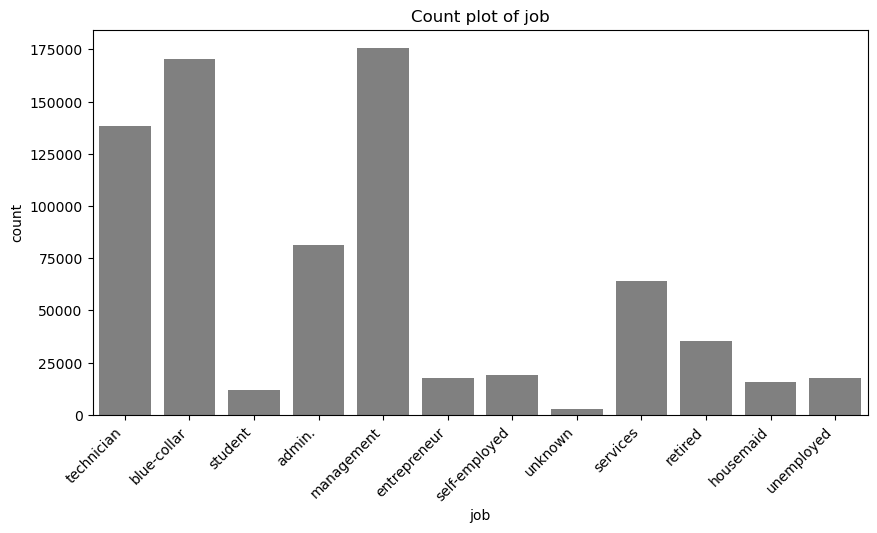

<Figure size 640x480 with 0 Axes>

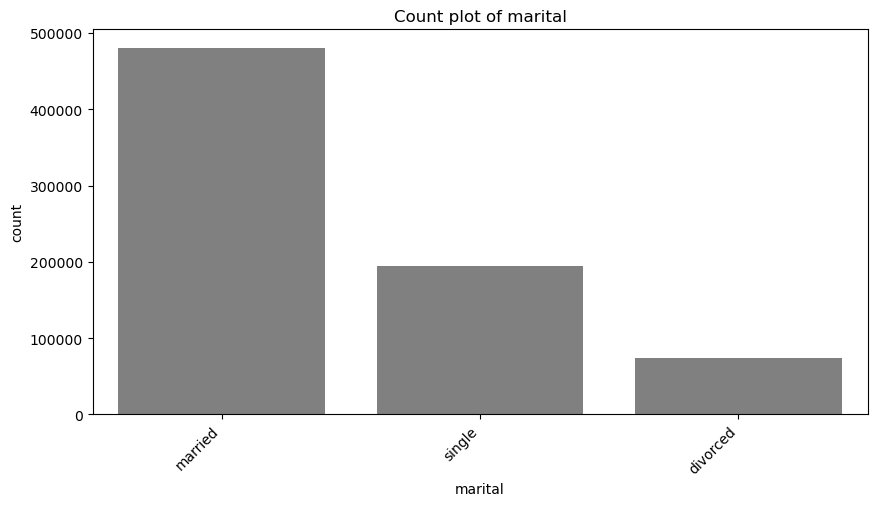

<Figure size 640x480 with 0 Axes>

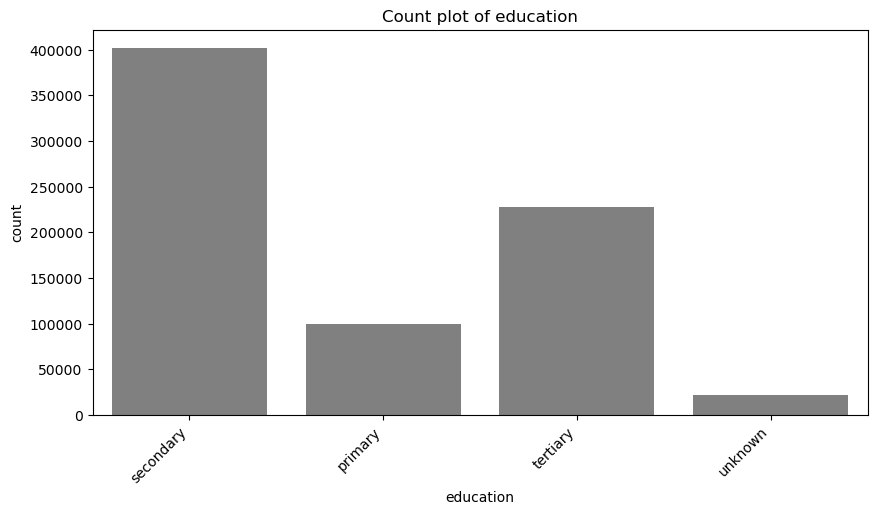

<Figure size 640x480 with 0 Axes>

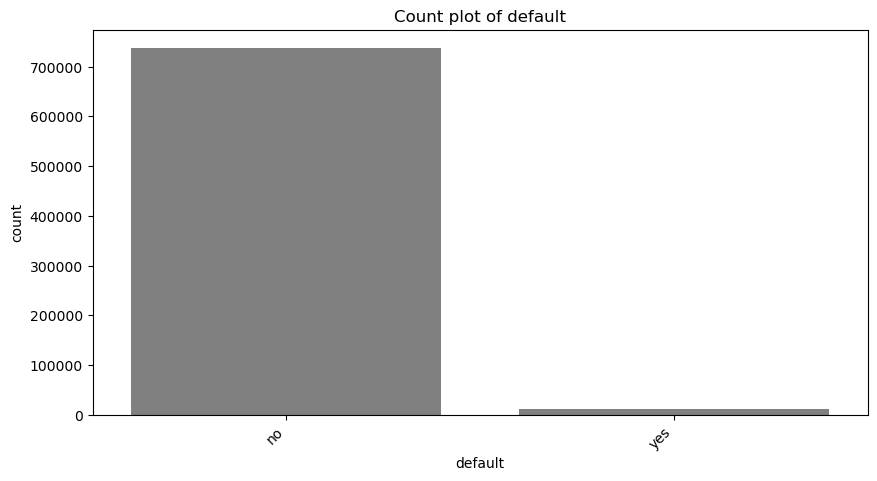

<Figure size 640x480 with 0 Axes>

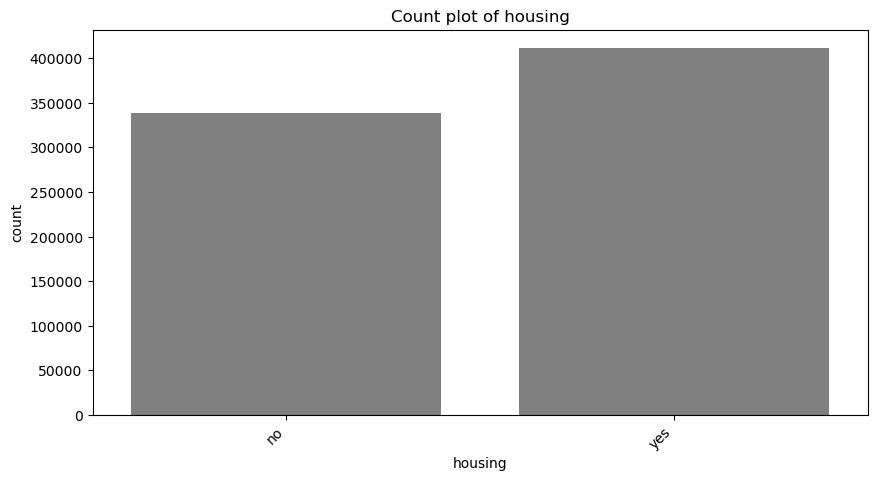

<Figure size 640x480 with 0 Axes>

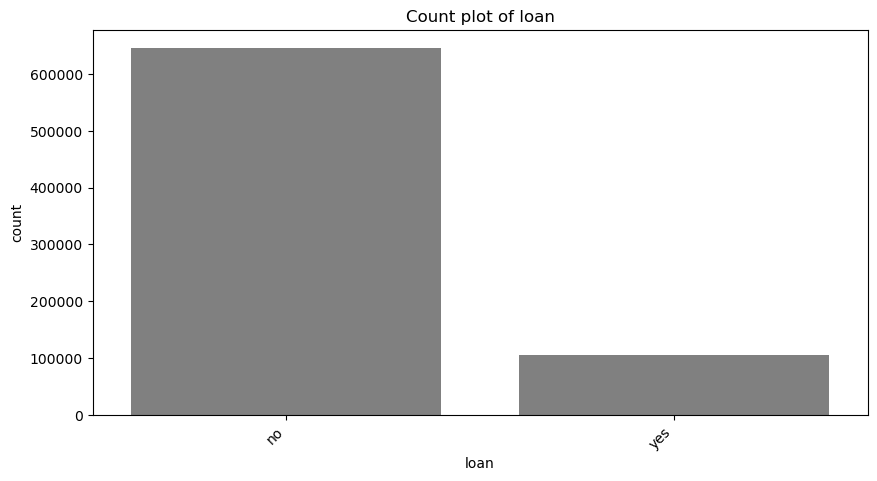

<Figure size 640x480 with 0 Axes>

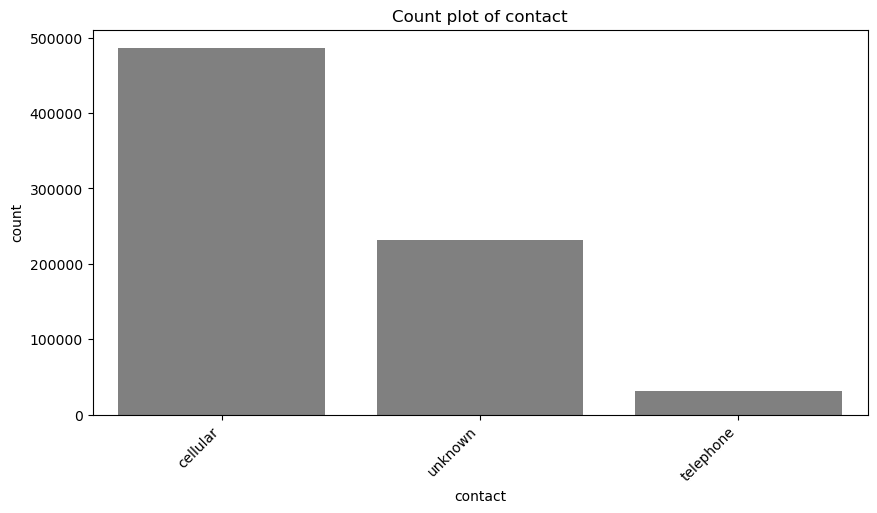

<Figure size 640x480 with 0 Axes>

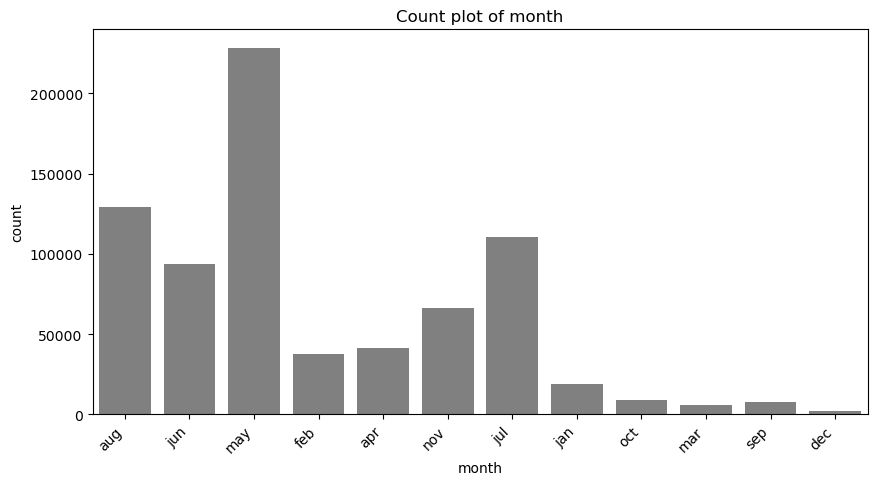

<Figure size 640x480 with 0 Axes>

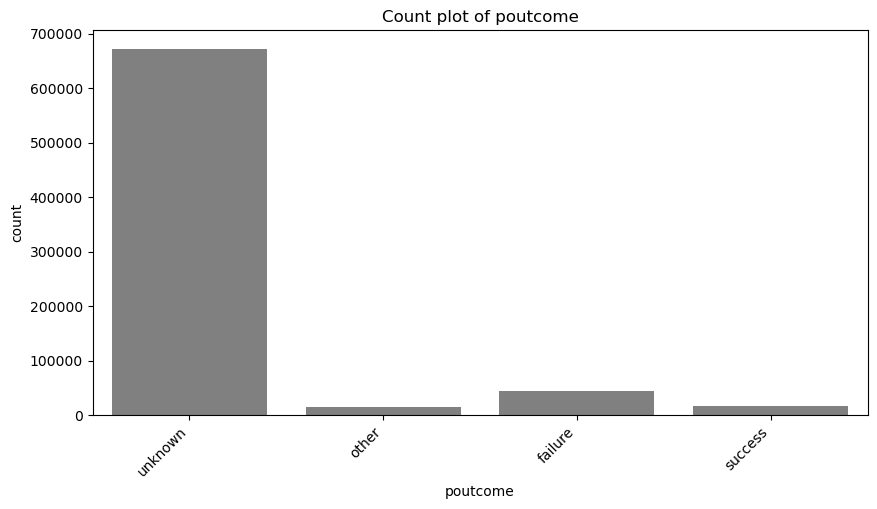

<Figure size 640x480 with 0 Axes>

In [121]:
cat_col = train_df.select_dtypes(include = 'O').columns
print(f"Categorical columns : {cat_col}")

for col in cat_col:
    plt.figure(figsize=(10,5))
    sns.countplot(x=train_df[col], color = "grey")  
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45, ha="right") 
    plt.show()
    plt.tight_layout()

In [122]:
for col in cat_col:
  print(f"Column Name : {train_df[col].value_counts()}\n\n")

Column Name : job
management       175541
blue-collar      170498
technician       138107
admin.            81492
services          64209
retired           35185
self-employed     19020
entrepreneur      17718
unemployed        17634
housemaid         15912
student           11767
unknown            2917
Name: count, dtype: int64


Column Name : marital
married     480759
single      194834
divorced     74407
Name: count, dtype: int64


Column Name : education
secondary    401683
tertiary     227508
primary       99510
unknown       21299
Name: count, dtype: int64


Column Name : default
no     737151
yes     12849
Name: count, dtype: int64


Column Name : housing
yes    411288
no     338712
Name: count, dtype: int64


Column Name : loan
no     645023
yes    104977
Name: count, dtype: int64


Column Name : contact
cellular     486655
unknown      231627
telephone     31718
Name: count, dtype: int64


Column Name : month
may    228411
aug    128859
jul    110647
jun     93670
nov     66

In [123]:
for col in cat_col:
  print(f"{col}:{train_df[col].unique()}\n")

job:['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']

marital:['married' 'single' 'divorced']

education:['secondary' 'primary' 'tertiary' 'unknown']

default:['no' 'yes']

housing:['no' 'yes']

loan:['no' 'yes']

contact:['cellular' 'unknown' 'telephone']

month:['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']

poutcome:['unknown' 'other' 'failure' 'success']



## Preprocessing

In [124]:
# Define encoding groups

label_col = ['default', 'housing', 'loan']
ohe_col=['job', 'marital', 'contact','poutcome']
ord_col = ['education', 'month']

In [125]:
edu_map = [['primary','secondary' ,'tertiary','unknown']]
month_map = [['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']]
label_map=[['no','yes']]

In [126]:
# Pipelines
ohe_pipe = Pipeline(steps =[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

label_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy = 'most_frequent')),
    ("ord",OrdinalEncoder(categories=label_map*len(label_col)))
])

ord_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy = 'most_frequent')),
    ("ord",OrdinalEncoder(categories=edu_map+month_map))
])

num_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy = 'median')),
    ("scaler",StandardScaler())
])

In [127]:
preprocessor = ColumnTransformer(transformers=[
    ("ohe", ohe_pipe, ohe_col),
    ("ord", ord_pipe, ord_col),
    ("label", label_pipe, label_col),
    ("num",num_pipe,num_col)], remainder="drop")

In [128]:
preprocessor

ColumnTransformer(transformers=[('ohe',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'contact', 'poutcome']),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['primary',
                                                                              'secondary',
                                                                              'tertiary',
                                                                              'unknown'],...
                                ('label',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['no',
                                                                              'yes'],
                                                                             ['no',
                                                                              'yes'],
                                                                             ['no',
                                                                              'yes']]))]),
                                 ['default', 'housing', 'loan']),
                                ('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'balance', 'day', 'duration',
                                  'campaign', 'pdays', 'previous'])])

## Model Creation

In [129]:
X=train_df.copy()
X.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown


In [130]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2, stratify = y, random_state =42)

In [131]:
print(f"X_train shape = {X_train.shape}")
print(f"X_val shape = {X_val.shape}")
print(f"y_train shape = {y_train.shape}")
print(f"y_val shape = {y_val.shape}")

X_train shape = (600000, 17)
X_val shape = (150000, 17)
y_train shape = (600000,)
y_val shape = (150000,)


In [132]:
# models
lr= LogisticRegression(max_iter = 1000,class_weight = 'balanced')


lgbm = LGBMClassifier(n_estimators=1000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)


xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=(1 - y.mean())/y.mean()
)

## Model Training

[LightGBM] [Info] Number of positive: 72390, number of negative: 527610
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


<Figure size 800x500 with 0 Axes>

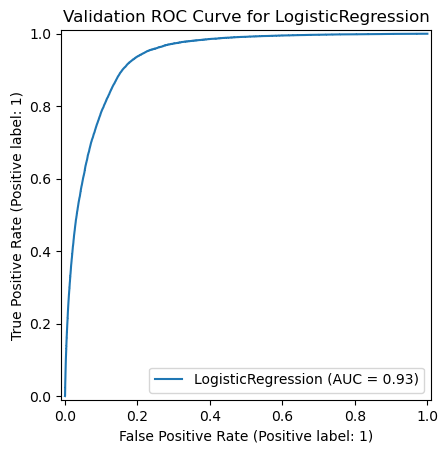

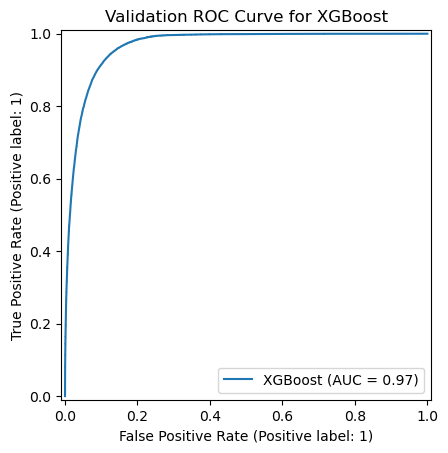

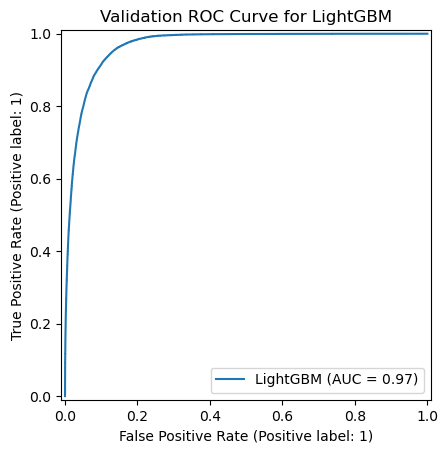

In [140]:
# pack your estimators
models = {
    "LogisticRegression": lr,
    "XGBoost": xgb,
    "LightGBM": lgbm            
}

results = []
probas = {}

plt.figure(figsize=(8,5))
for name, est in models.items():
    # fresh pipeline for each model
    pipe = Pipeline([("prep", preprocessor), ("clf", clone(est))])
    pipe.fit(X_train, y_train)

    val_proba = pipe.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_proba)
    results.append({"model": name, "val_auc": auc})
    probas[name] = (pipe, val_proba)  
    
    RocCurveDisplay.from_predictions(y_val, val_proba, name=name)
    plt.title(f"Validation ROC Curve for {name}")
plt.show()



In [135]:
# rank models
score_df = pd.DataFrame(results).sort_values("val_auc", ascending=False).reset_index(drop=True)
print("\nValidation ROC-AUC ranking:")
print(score_df)




Validation ROC-AUC ranking:
                model   val_auc
0            LightGBM  0.968000
1             XGBoost  0.967222
2  LogisticRegression  0.934624


## Pick best model

In [136]:
# pick best
best_name = score_df.loc[0, "model"]
best_pipe, best_val_proba = probas[best_name]
print(f"\nBest model on validation: {best_name} (AUC={score_df.loc[0, 'val_auc']:.5f})")




Best model on validation: LightGBM (AUC=0.96800)


## Testing best model

In [137]:
# ===== Fit best model on ALL training data and predict test =====
best_model = Pipeline([("prep", preprocessor), ("clf", clone(models[best_name]))])
best_model.fit(X, y)

y_test_pred_proba = best_model.predict_proba(test_df)[:, 1]



[LightGBM] [Info] Number of positive: 90488, number of negative: 659512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


## Submission file

In [138]:
# save submission
submission = pd.DataFrame({'id': test_df['id'],'y': y_test_pred_proba})
submission.to_csv("submission.csv", index=False)
print("\nSaved submission.csv using best model:", best_name)



Saved submission.csv using best model: LightGBM


In [139]:
submission.head(5)

,id,y
0,750000,0.013807
1,750001,0.319067
2,750002,0.000575
3,750003,0.000097
4,750004,0.103102
